In [ ]:
!wget -N https://codescore.ddns.net/image/data.json

--2024-01-24 14:54:47--  https://codescore.ddns.net/image/data.json
Resolving codescore.ddns.net (codescore.ddns.net)... 118.70.123.41
Connecting to codescore.ddns.net (codescore.ddns.net)|118.70.123.41|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘data.json’ not modified on server. Omitting download.



In [ ]:
!wget -N https://raw.githubusercontent.com/stopwords/vietnamese-stopwords/master/vietnamese-stopwords.txt

--2024-01-24 14:54:49--  https://raw.githubusercontent.com/stopwords/vietnamese-stopwords/master/vietnamese-stopwords.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 20475 (20K) [text/plain]
Saving to: ‘vietnamese-stopwords.txt’

vietnamese-stopword 100%[===================>]  20.00K  --.-KB/s    in 0.001s  

Last-modified header missing -- time-stamps turned off.
2024-01-24 14:54:49 (20.3 MB/s) - ‘vietnamese-stopwords.txt’ saved [20475/20475]



In [ ]:
!pip install underthesea

In [ ]:
from gensim.models import Word2Vec
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
import gensim
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
import json
import pandas as pd
import numpy as np
import string
import re
import underthesea

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [ ]:
with open("data.json", "r", encoding="utf8") as f:
  data = json.load(f)

In [ ]:
preprocess_data = pd.DataFrame([{"content": x["title"] + " " + x["desc"] + " " + x["detail"], "label": x["label"]} for x in data])
preprocess_data

,content,label
0,"Bất bình đẳng cơ hội Mới đây, sau chuyến về t...",no
1,Trung Quốc chỉ trích Hà Lan vì hạn chế xuất kh...,no
2,"Ford theo bước Toyota, giảm xe điện, tăng cườn...",no
3,Có an toàn khi đi du lịch Nhật Bản bây giờ? T...,no
4,"Tổng thống Joko Widodo muốn Vietjet Air, FPT đ...",no
...,...,...
1100,Chồng đại gia của Thu Thảo dành lời ngọt ngào ...,no
1101,"Giao dịch 38 kg pháo hoa nổ, 2 người đàn ông l...",no
1102,Tạm hoãn xuất cảnh Giám đốc công ty cổ phần kh...,no
1103,Vượt đèo Mẻ Pia 14 tầng để khám phá 'vua đèo' ...,no


In [ ]:
preprocess_data["label"].value_counts(normalize=True)

no         0.866063
yes        0.119457
unknown    0.014480
Name: label, dtype: float64

<Axes: >

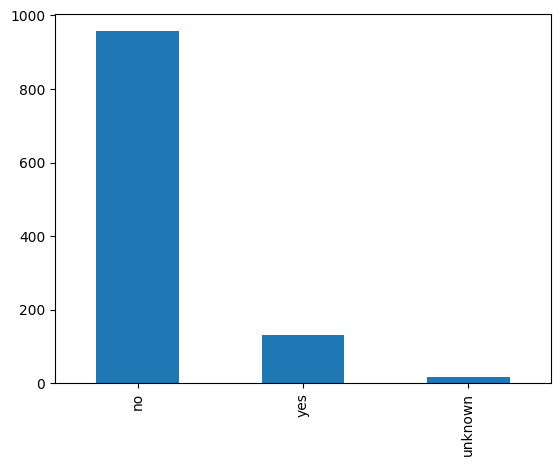

In [ ]:
preprocess_data["label"].value_counts().plot(kind='bar')

In [ ]:
# Remove unknown data
preprocess_data.drop(preprocess_data[preprocess_data.label == "unknown"].index, inplace=True)
preprocess_data

,content,label
0,"Bất bình đẳng cơ hội Mới đây, sau chuyến về t...",no
1,Trung Quốc chỉ trích Hà Lan vì hạn chế xuất kh...,no
2,"Ford theo bước Toyota, giảm xe điện, tăng cườn...",no
3,Có an toàn khi đi du lịch Nhật Bản bây giờ? T...,no
4,"Tổng thống Joko Widodo muốn Vietjet Air, FPT đ...",no
...,...,...
1100,Chồng đại gia của Thu Thảo dành lời ngọt ngào ...,no
1101,"Giao dịch 38 kg pháo hoa nổ, 2 người đàn ông l...",no
1102,Tạm hoãn xuất cảnh Giám đốc công ty cổ phần kh...,no
1103,Vượt đèo Mẻ Pia 14 tầng để khám phá 'vua đèo' ...,no


In [ ]:
# Make lowercase
def text_lowercase(txt):
  return txt.lower()

preprocess_data["content"] = preprocess_data["content"].apply(text_lowercase)
preprocess_data

,content,label
0,"bất bình đẳng cơ hội mới đây, sau chuyến về t...",no
1,trung quốc chỉ trích hà lan vì hạn chế xuất kh...,no
2,"ford theo bước toyota, giảm xe điện, tăng cườn...",no
3,có an toàn khi đi du lịch nhật bản bây giờ? t...,no
4,"tổng thống joko widodo muốn vietjet air, fpt đ...",no
...,...,...
1100,chồng đại gia của thu thảo dành lời ngọt ngào ...,no
1101,"giao dịch 38 kg pháo hoa nổ, 2 người đàn ông l...",no
1102,tạm hoãn xuất cảnh giám đốc công ty cổ phần kh...,no
1103,vượt đèo mẻ pia 14 tầng để khám phá 'vua đèo' ...,no


In [ ]:
def remove_punctuation(text):
  translator = str.maketrans('', '', string.punctuation)
  return text.translate(translator)

preprocess_data["content"] = preprocess_data["content"].apply(remove_punctuation)
preprocess_data

,content,label
0,bất bình đẳng cơ hội mới đây sau chuyến về th...,no
1,trung quốc chỉ trích hà lan vì hạn chế xuất kh...,no
2,ford theo bước toyota giảm xe điện tăng cường ...,no
3,có an toàn khi đi du lịch nhật bản bây giờ tr...,no
4,tổng thống joko widodo muốn vietjet air fpt đầ...,no
...,...,...
1100,chồng đại gia của thu thảo dành lời ngọt ngào ...,no
1101,giao dịch 38 kg pháo hoa nổ 2 người đàn ông li...,no
1102,tạm hoãn xuất cảnh giám đốc công ty cổ phần kh...,no
1103,vượt đèo mẻ pia 14 tầng để khám phá vua đèo vi...,no


In [ ]:
def remove_whitespace(text):
  return " ".join(text.split())

preprocess_data["content"] = preprocess_data["content"].apply(remove_whitespace)
preprocess_data

,content,label
0,bất bình đẳng cơ hội mới đây sau chuyến về thă...,no
1,trung quốc chỉ trích hà lan vì hạn chế xuất kh...,no
2,ford theo bước toyota giảm xe điện tăng cường ...,no
3,có an toàn khi đi du lịch nhật bản bây giờ trậ...,no
4,tổng thống joko widodo muốn vietjet air fpt đầ...,no
...,...,...
1100,chồng đại gia của thu thảo dành lời ngọt ngào ...,no
1101,giao dịch 38 kg pháo hoa nổ 2 người đàn ông li...,no
1102,tạm hoãn xuất cảnh giám đốc công ty cổ phần kh...,no
1103,vượt đèo mẻ pia 14 tầng để khám phá vua đèo vi...,no


In [ ]:
with open("vietnamese-stopwords.txt", encoding="utf8") as f:
  stopwords = [x.strip() for x in f.readlines()]

In [ ]:
def remove_stopwords(txt):
  temp = [x for x in underthesea.word_tokenize(txt) if x not in stopwords]
  return " ".join(temp)

preprocess_data["content"] = preprocess_data["content"].apply(remove_stopwords)
preprocess_data

,content,label
0,bất bình đẳng chuyến thăm quê thành phố miền t...,no
1,trung quốc chỉ trích hà lan hạn chế xuất khẩu ...,no
2,ford toyota xe điện tăng cường xe hybrid doanh...,no
3,an toàn đi du lịch nhật bản trận động đất 76 đ...,no
4,tổng thống joko widodo vietjet air fpt đầu tư ...,no
...,...,...
1100,chồng đại gia thu thảo ngọt ngào vợ dịp sinh n...,no
1101,giao dịch 38 kg pháo hoa nổ 2 đàn ông liên lụy...,no
1102,tạm hoãn xuất cảnh giám đốc công ty cổ phần kh...,no
1103,đèo mẻ pia 14 tầng khám phá vua đèo việt nam 2...,no


In [ ]:
def label_to_num(label):
  return 0 if label == "no" else 1

preprocess_data["label"] = preprocess_data["label"].apply(label_to_num)
preprocess_data

,content,label
0,bất bình đẳng chuyến thăm quê thành phố miền t...,0
1,trung quốc chỉ trích hà lan hạn chế xuất khẩu ...,0
2,ford toyota xe điện tăng cường xe hybrid doanh...,0
3,an toàn đi du lịch nhật bản trận động đất 76 đ...,0
4,tổng thống joko widodo vietjet air fpt đầu tư ...,0
...,...,...
1100,chồng đại gia thu thảo ngọt ngào vợ dịp sinh n...,0
1101,giao dịch 38 kg pháo hoa nổ 2 đàn ông liên lụy...,0
1102,tạm hoãn xuất cảnh giám đốc công ty cổ phần kh...,0
1103,đèo mẻ pia 14 tầng khám phá vua đèo việt nam 2...,0


In [ ]:
X_train_ori, X_test_ori, y_train, y_test = train_test_split(preprocess_data["content"], preprocess_data["label"], test_size=0.2, train_size=0.8, stratify=preprocess_data["label"])

# Bag of Words (CountVectorizer)

In [ ]:
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(X_train_ori)
X_test = vectorizer.transform(X_test_ori)

In [ ]:
model_bow = LogisticRegression()
model_bow.fit(X_train, y_train)

LogisticRegression()

In [ ]:
y_pred = model_bow.predict(X_test)

In [ ]:
print(classification_report(y_test, y_pred, target_names=["Không nhạy cảm", "Nhạy cảm"]))

                precision    recall  f1-score   support

Không nhạy cảm       0.94      0.97      0.96       192
      Nhạy cảm       0.71      0.58      0.64        26

      accuracy                           0.92       218
     macro avg       0.83      0.77      0.80       218
  weighted avg       0.92      0.92      0.92       218



# Word2Vec

In [ ]:
X_train_token = X_train_ori.apply(underthesea.word_tokenize).to_list()
X_test_token = X_test_ori.apply(underthesea.word_tokenize).to_list()
print(X_train_token[:2])

[['asian', 'cup', '2023', 'tuyển', 'palestine nhắm', 'lịch sử', 'trận', 'hòa', 'tích cực', 'uae', 'hlv', 'makram', 'daboud', 'học trò', 'đội tuyển', 'palestine', 'lịch sử', 'giành', 'quyền', 'lọt', 'vòng', 'đấu', 'asian', 'cup', 'trận', 'hòa', '11', '10', 'uae', 'lượt', 'trận', '2', 'bảng', 'c', 'niềm', 'vui', 'palestine', 'bàn', 'thắng gỡ', 'hòa tuyển', 'palestine', 'trận', 'đấu', '2', 'asian', 'cup', '2023', 'bối cảnh', 'chiến tranh', 'diễn dải', 'gaza', 'cầu thủ', 'đội', 'người thân', 'gia đình', 'mắc kẹt', 'khu vực', 'nguy hiểm', 'toàn tâm', 'toàn ý', 'bóng', 'khoảnh khắc', 'im lặng', 'ngắn ngủi', 'tổ chức', 'trận', 'đấu', 'uae', 'svđ al', 'janoub al', 'wakrah', 'cầu thủ', 'palestine', 'thi đấu', 'cực kỳ', 'quả cảm', 'cổ động', 'đám', 'đông', '40', 'ngàn', 'con người', 'tuyển', 'palestine', 'lâm tình thế', 'bất lợi', 'uae', 'tỷ số', 'trận', 'đấu', 'phút', '23', 'công sultan', 'adil', 'thế trận', 'palestine hưởng', 'phạt đền', 'phút', '37', 'hậu vệ', 'khalifa', 'alhammadi', 'uae', '

In [ ]:
w2v = Word2Vec(X_train_token, vector_size=350, window=5, min_count=1, epochs=20)
w2v.wv.most_similar(['người'])

[('thư sinh', 0.9622911810874939),
 ('dâu', 0.9620649218559265),
 ('bồi rèn', 0.9612427353858948),
 ('cortisol', 0.959163248538971),
 ('tiếp phận', 0.958036482334137),
 ('thường ngày', 0.9570033550262451),
 ('hãy vặn', 0.9568833112716675),
 ('lâm hậu', 0.9563440680503845),
 ('mồ hôi', 0.9562005996704102),
 ('sồi', 0.9561718106269836)]

In [ ]:
def document_vector_mean(doc):
    """Create document vectors by averaging word vectors. Remove out-of-vocabulary words."""
    doc = [word for word in doc if word in w2v.wv]
    return np.mean(w2v.wv[doc], axis=0)

X_train = np.array([document_vector_mean(doc) for doc in X_train_token])
X_test = np.array([document_vector_mean(doc) for doc in X_test_token])
X_train

array([[-0.20507154,  0.4679593 , -0.28793788, ..., -0.6836867 ,
        -0.34021544, -0.13804948],
       [-0.06542946,  0.03664572, -0.15198365, ..., -0.04227925,
        -0.21815026, -0.0316199 ],
       [ 0.14321508, -0.13813342, -0.24786909, ..., -0.20786718,
        -0.37879813,  0.0107281 ],
       ...,
       [ 0.33482707, -0.26075226, -0.41704354, ...,  0.0560164 ,
        -0.13803911, -0.07924906],
       [-0.03864593,  0.08829874, -0.38577822, ..., -0.39597806,
        -0.22912158, -0.15344128],
       [ 0.25115818, -0.00103537, -0.15381837, ..., -0.38906756,
        -0.26760286, -0.06796279]], dtype=float32)

In [ ]:
model = LogisticRegression()
params = {
    'C' : [0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0],
    'class_weight' : ['balanced', None],
    'solver' : ['liblinear', 'lbfgs'],
    'max_iter' : [200]
}
grid = GridSearchCV(model, param_grid=params, scoring='f1', verbose=3)

In [ ]:
grid.fit(X_train, y_train)
print(grid.best_params_)
print(grid.best_score_)

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END C=0.5, class_weight=balanced, max_iter=200, solver=liblinear;, score=0.679 total time=   0.0s
[CV 2/5] END C=0.5, class_weight=balanced, max_iter=200, solver=liblinear;, score=0.824 total time=   0.1s
[CV 3/5] END C=0.5, class_weight=balanced, max_iter=200, solver=liblinear;, score=0.567 total time=   0.1s
[CV 4/5] END C=0.5, class_weight=balanced, max_iter=200, solver=liblinear;, score=0.625 total time=   0.1s
[CV 5/5] END C=0.5, class_weight=balanced, max_iter=200, solver=liblinear;, score=0.581 total time=   0.1s
[CV 1/5] END C=0.5, class_weight=balanced, max_iter=200, solver=lbfgs;, score=0.667 total time=   0.0s
[CV 2/5] END C=0.5, class_weight=balanced, max_iter=200, solver=lbfgs;, score=0.808 total time=   0.0s
[CV 3/5] END C=0.5, class_weight=balanced, max_iter=200, solver=lbfgs;, score=0.585 total time=   0.0s
[CV 4/5] END C=0.5, class_weight=balanced, max_iter=200, solver=lbfgs;, score=0.646 total time

In [ ]:
model_w2v = LogisticRegression(**grid.best_params_)
model_w2v.fit(X_train, y_train)

LogisticRegression(C=1.1, max_iter=200, solver='liblinear')

In [ ]:
y_pred = model_w2v.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["Không nhạy cảm", "Nhạy cảm"]))

                precision    recall  f1-score   support

Không nhạy cảm       0.94      0.98      0.96       192
      Nhạy cảm       0.76      0.50      0.60        26

      accuracy                           0.92       218
     macro avg       0.85      0.74      0.78       218
  weighted avg       0.91      0.92      0.91       218



# Doc2Vec

In [ ]:
X_train = [TaggedDocument(words=doc, tags=[i]) for i, doc in enumerate(X_train_token)]
X_train[0]

TaggedDocument(words=['asian', 'cup', '2023', 'tuyển', 'palestine nhắm', 'lịch sử', 'trận', 'hòa', 'tích cực', 'uae', 'hlv', 'makram', 'daboud', 'học trò', 'đội tuyển', 'palestine', 'lịch sử', 'giành', 'quyền', 'lọt', 'vòng', 'đấu', 'asian', 'cup', 'trận', 'hòa', '11', '10', 'uae', 'lượt', 'trận', '2', 'bảng', 'c', 'niềm', 'vui', 'palestine', 'bàn', 'thắng gỡ', 'hòa tuyển', 'palestine', 'trận', 'đấu', '2', 'asian', 'cup', '2023', 'bối cảnh', 'chiến tranh', 'diễn dải', 'gaza', 'cầu thủ', 'đội', 'người thân', 'gia đình', 'mắc kẹt', 'khu vực', 'nguy hiểm', 'toàn tâm', 'toàn ý', 'bóng', 'khoảnh khắc', 'im lặng', 'ngắn ngủi', 'tổ chức', 'trận', 'đấu', 'uae', 'svđ al', 'janoub al', 'wakrah', 'cầu thủ', 'palestine', 'thi đấu', 'cực kỳ', 'quả cảm', 'cổ động', 'đám', 'đông', '40', 'ngàn', 'con người', 'tuyển', 'palestine', 'lâm tình thế', 'bất lợi', 'uae', 'tỷ số', 'trận', 'đấu', 'phút', '23', 'công sultan', 'adil', 'thế trận', 'palestine hưởng', 'phạt đền', 'phút', '37', 'hậu vệ', 'khalifa', '

In [ ]:
d2v = gensim.models.doc2vec.Doc2Vec(vector_size=350, min_count=1, epochs=40)
d2v.build_vocab(X_train)
d2v.train(X_train, total_examples=d2v.corpus_count, epochs=d2v.epochs)

In [ ]:
X_train = np.array([d2v.infer_vector(doc) for doc in X_train_token])
X_test = np.array([d2v.infer_vector(doc) for doc in X_test_token])
X_train

array([[ 0.90136737,  0.6149089 ,  0.33565336, ..., -2.3035493 ,
        -1.2248981 ,  0.6036943 ],
       [-0.21438088,  0.13215248,  0.5804006 , ...,  1.0641196 ,
        -0.29976937,  0.8818201 ],
       [-0.12078901, -0.05246575, -0.0492664 , ...,  0.47440603,
        -2.0034378 ,  0.28033346],
       ...,
       [ 0.41490316, -0.02646349, -0.08353824, ...,  0.1965286 ,
        -0.48313737,  0.7711604 ],
       [ 0.6355712 , -0.53895   , -0.26018068, ..., -1.0866737 ,
        -0.55447525, -0.055533  ],
       [ 0.14703159,  0.38705662,  0.06950452, ..., -0.774645  ,
        -1.4999545 , -0.16348812]], dtype=float32)

In [ ]:
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

In [ ]:
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, target_names=["Không nhạy cảm", "Nhạy cảm"]))

                precision    recall  f1-score   support

Không nhạy cảm       0.97      0.76      0.85       192
      Nhạy cảm       0.32      0.85      0.46        26

      accuracy                           0.77       218
     macro avg       0.65      0.80      0.66       218
  weighted avg       0.90      0.77      0.80       218



# PhoBERT

In [ ]:
%pip install transformers[torch] datasets evaluate

In [ ]:
import torch
from transformers import AutoModel, AutoTokenizer, Trainer
from transformers import AutoModelForSequenceClassification, TrainingArguments
import evaluate
from datasets import Dataset

In [ ]:
X, X_test_ori, y, y_test = train_test_split(preprocess_data["content"], preprocess_data["label"], test_size=0.2, train_size=0.8, stratify=preprocess_data["label"])
X_train_ori, X_dev_ori, y_train, y_dev = train_test_split(X, y, test_size=0.25, train_size=0.75, stratify=y)

<Axes: >

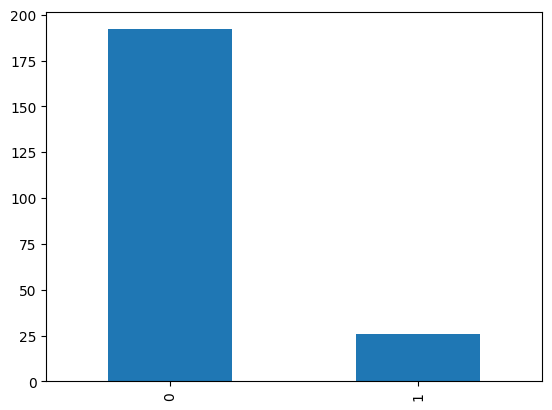

In [ ]:
y_test.value_counts().plot(kind='bar')

<Axes: >

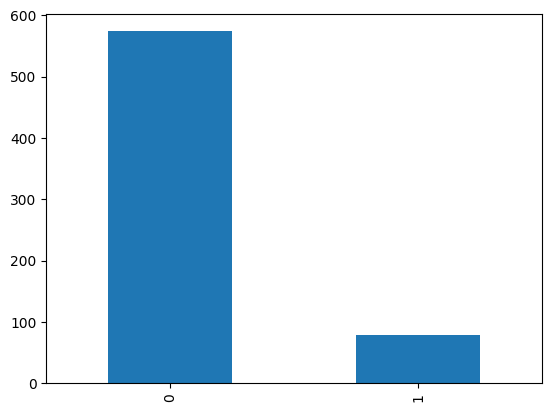

In [ ]:
y_train.value_counts().plot(kind='bar')

<Axes: >

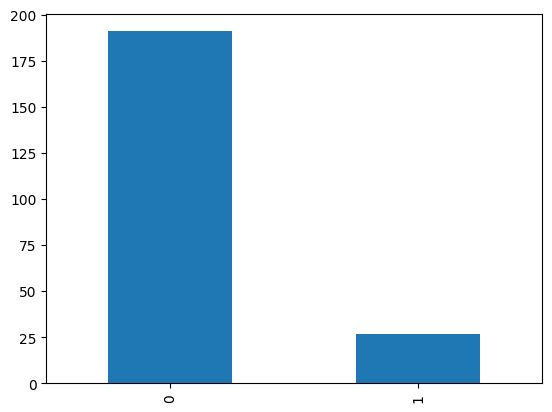

In [ ]:
y_dev.value_counts().plot(kind='bar')

In [ ]:
X_train_token = X_train_ori.apply(underthesea.word_tokenize).to_list()
X_test_token = X_test_ori.apply(underthesea.word_tokenize).to_list()
X_dev_token = X_dev_ori.apply(underthesea.word_tokenize).to_list()
print(X_train_token[:2])

[['làng', 'bánh', 'mứt', 'tết', 'truyền thống', 'đỏ', 'lửa', 'mùa', 'suốt', 'cận', 'tết nguyên đán', 'làng nghề', 'sản xuất', 'bánh thuẫn', 'mứt gừng', 'truyền thống', 'thừa', 'thiên huế', 'tất bật', 'mùa', 'sản xuất', 'thậm chí thức', 'đêm thức', 'hôm', 'kịp', 'sản lượng', 'phục vục', 'thị trường', 'lò', 'bánh thuẫn', 'thôn', 'hiền an', '1', 'xã', 'vinh hiền', 'huyện', 'phú lộc', 'tỉnh', 'thừa', 'thiên huế', 'đỏ', 'lửa', 'mùa', 'cận', 'tết', 'nghề', 'ngủ', 'đêm', 'làng', 'hiền an', '1', 'nằm', 'cửa biển', 'tư', 'hiền xã', 'vinh hiền', 'huyện', 'phú lộc', 'tỉnh', 'thừa', 'thiên huế', 'đa số', 'dân cư', 'quanh năm', 'gắn bó', 'nghề', 'ngư nghiệp', 'đàn ông', 'vươn', 'khơi', 'đánh bắt', 'nuôi trồng', 'thủy', 'hải sản', 'phụ nữ', 'chuyên', 'lo', 'bán buôn', 'sản phẩm', 'chồng con', 'khai thác', 'biển cả', 'đầm', 'cầu', 'hai', 'bờ', 'cạnh', 'dân làng', 'hiền an', '1', 'lưu giữ', 'nghề', 'truyền thống', 'lâu đời', 'đỏ', 'lửa', 'dịp', 'cận', 'tết âm lịch', 'hàng', 'nghề', 'bánh thuẫn', 'nguy

In [ ]:
X_train = [" ".join([y.replace(" ", "_") for y in x]) for x in X_train_token]
X_test = [" ".join([y.replace(" ", "_") for y in x]) for x in X_test_token]
X_dev = [" ".join([y.replace(" ", "_") for y in x]) for x in X_dev_token]
X_train[0]

'làng bánh mứt tết truyền_thống đỏ lửa mùa suốt cận tết_nguyên_đán làng_nghề sản_xuất bánh_thuẫn mứt_gừng truyền_thống thừa thiên_huế tất_bật mùa sản_xuất thậm_chí_thức đêm_thức hôm kịp sản_lượng phục_vục thị_trường lò bánh_thuẫn thôn hiền_an 1 xã vinh_hiền huyện phú_lộc tỉnh thừa thiên_huế đỏ lửa mùa cận tết nghề ngủ đêm làng hiền_an 1 nằm cửa_biển tư hiền_xã vinh_hiền huyện phú_lộc tỉnh thừa thiên_huế đa_số dân_cư quanh_năm gắn_bó nghề ngư_nghiệp đàn_ông vươn khơi đánh_bắt nuôi_trồng thủy hải_sản phụ_nữ chuyên lo bán_buôn sản_phẩm chồng_con khai_thác biển_cả đầm cầu hai bờ cạnh dân_làng hiền_an 1 lưu_giữ nghề truyền_thống lâu_đời đỏ lửa dịp cận tết_âm_lịch hàng nghề bánh_thuẫn nguyên_liệu bánh chủ_yếu bột củ bình_tinh gọi là dong trắng_dong ta trứng gà vịt đường cát trắng việt_quất gắp chiến_bánh chín nở khuôn_bếp than đỏ lửa bôi dầu nguyên_liệu làm_mẻ công_việc quen_thuộc thợ bánh_thuẫn lò sản_xuất bánh_thuẫn nguyễn_thị_xê nằm đầu cầu tư_hiền_mẻ bánh đặng_thị_kim chi người_dân thôn 

In [ ]:
train_ds = Dataset.from_dict({"text": X_train, "label":y_train})
test_ds = Dataset.from_dict({"text": X_test, "label":y_test})
dev_ds = Dataset.from_dict({"text": X_dev, "label":y_dev})
train_ds[0]

{'text': 'làng bánh mứt tết truyền_thống đỏ lửa mùa suốt cận tết_nguyên_đán làng_nghề sản_xuất bánh_thuẫn mứt_gừng truyền_thống thừa thiên_huế tất_bật mùa sản_xuất thậm_chí_thức đêm_thức hôm kịp sản_lượng phục_vục thị_trường lò bánh_thuẫn thôn hiền_an 1 xã vinh_hiền huyện phú_lộc tỉnh thừa thiên_huế đỏ lửa mùa cận tết nghề ngủ đêm làng hiền_an 1 nằm cửa_biển tư hiền_xã vinh_hiền huyện phú_lộc tỉnh thừa thiên_huế đa_số dân_cư quanh_năm gắn_bó nghề ngư_nghiệp đàn_ông vươn khơi đánh_bắt nuôi_trồng thủy hải_sản phụ_nữ chuyên lo bán_buôn sản_phẩm chồng_con khai_thác biển_cả đầm cầu hai bờ cạnh dân_làng hiền_an 1 lưu_giữ nghề truyền_thống lâu_đời đỏ lửa dịp cận tết_âm_lịch hàng nghề bánh_thuẫn nguyên_liệu bánh chủ_yếu bột củ bình_tinh gọi là dong trắng_dong ta trứng gà vịt đường cát trắng việt_quất gắp chiến_bánh chín nở khuôn_bếp than đỏ lửa bôi dầu nguyên_liệu làm_mẻ công_việc quen_thuộc thợ bánh_thuẫn lò sản_xuất bánh_thuẫn nguyễn_thị_xê nằm đầu cầu tư_hiền_mẻ bánh đặng_thị_kim chi người_

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base-v2")

In [ ]:
def tokenize_function(x):
    return tokenizer(x["text"], padding="max_length", truncation=True, max_length=256)

train_ds_token = train_ds.map(tokenize_function, batched=True)
test_ds_token = test_ds.map(tokenize_function, batched=True)
dev_ds_token = dev_ds.map(tokenize_function, batched=True)
print(train_ds_token[0])

Map:   0%|          | 0/653 [00:00<?, ? examples/s]

Map:   0%|          | 0/218 [00:00<?, ? examples/s]

Map:   0%|          | 0/218 [00:00<?, ? examples/s]

{'text': 'làng bánh mứt tết truyền_thống đỏ lửa mùa suốt cận tết_nguyên_đán làng_nghề sản_xuất bánh_thuẫn mứt_gừng truyền_thống thừa thiên_huế tất_bật mùa sản_xuất thậm_chí_thức đêm_thức hôm kịp sản_lượng phục_vục thị_trường lò bánh_thuẫn thôn hiền_an 1 xã vinh_hiền huyện phú_lộc tỉnh thừa thiên_huế đỏ lửa mùa cận tết nghề ngủ đêm làng hiền_an 1 nằm cửa_biển tư hiền_xã vinh_hiền huyện phú_lộc tỉnh thừa thiên_huế đa_số dân_cư quanh_năm gắn_bó nghề ngư_nghiệp đàn_ông vươn khơi đánh_bắt nuôi_trồng thủy hải_sản phụ_nữ chuyên lo bán_buôn sản_phẩm chồng_con khai_thác biển_cả đầm cầu hai bờ cạnh dân_làng hiền_an 1 lưu_giữ nghề truyền_thống lâu_đời đỏ lửa dịp cận tết_âm_lịch hàng nghề bánh_thuẫn nguyên_liệu bánh chủ_yếu bột củ bình_tinh gọi là dong trắng_dong ta trứng gà vịt đường cát trắng việt_quất gắp chiến_bánh chín nở khuôn_bếp than đỏ lửa bôi dầu nguyên_liệu làm_mẻ công_việc quen_thuộc thợ bánh_thuẫn lò sản_xuất bánh_thuẫn nguyễn_thị_xê nằm đầu cầu tư_hiền_mẻ bánh đặng_thị_kim chi người_

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base-v2", num_labels=2)
training_args = TrainingArguments(output_dir="test_trainer", evaluation_strategy="epoch", num_train_epochs=10, logging_steps=100)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base-v2 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
metric = evaluate.load("f1")
def compute_metrics(eval_pred, multi=False):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, labels=[0,1], average=None if multi else "binary")

In [ ]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds_token,
    eval_dataset=dev_ds_token,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss,F1
1,No log,0.290833,0.613636
2,0.373100,0.111528,0.823529
3,0.197700,0.258194,0.619048
4,0.109000,0.191849,0.843750
5,0.145600,0.192982,0.701299
6,0.145600,0.336932,0.636364
7,0.137100,0.212379,0.727273
8,0.129300,0.190642,0.697674
9,0.059800,0.110630,0.872727
10,0.058100,0.108001,0.896552


TrainOutput(global_step=820, training_loss=0.14821297184723178, metrics={'train_runtime': 984.7199, 'train_samples_per_second': 6.631, 'train_steps_per_second': 0.833, 'total_flos': 859057595750400.0, 'train_loss': 0.14821297184723178, 'epoch': 10.0})

In [ ]:
pred = trainer.predict(test_ds_token)

In [ ]:
def compute_metrics_temp(eval_pred):
    logits, labels, _ = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels, labels=[0,1], average=None)

In [ ]:
metric = evaluate.load("f1")
compute_metrics_temp(pred)

{'f1': array([0.95514512, 0.70175439])}

In [ ]:
metric = evaluate.load("recall")
compute_metrics_temp(pred)

{'recall': array([0.94270833, 0.76923077])}

In [ ]:
metric = evaluate.load("precision")
compute_metrics_temp(pred)

{'precision': array([0.96791444, 0.64516129])}

In [ ]:
def pred2classes(predictions):
  classes = [1 if x < y else 0 for x, y in predictions]
  return classes

In [ ]:
print(classification_report(test_ds['label'], pred2classes(pred.predictions), target_names=["Không nhạy cảm", "Nhạy cảm"]))

                precision    recall  f1-score   support

Không nhạy cảm       0.97      0.94      0.96       192
      Nhạy cảm       0.65      0.77      0.70        26

      accuracy                           0.92       218
     macro avg       0.81      0.86      0.83       218
  weighted avg       0.93      0.92      0.92       218



# Inference

In [ ]:
def preprocessing(doc):
  doc = text_lowercase(doc)
  doc = remove_punctuation(doc)
  doc = remove_whitespace(doc)
  doc = remove_stopwords(doc)
  return doc

In [ ]:
def w2v_preprocessing(doc):
  doc = preprocessing(doc)

  doc = underthesea.word_tokenize(doc)
  token = document_vector_mean(doc)
  return token

In [ ]:
def phobert_preprocessing(doc):
  doc = preprocessing(doc)

  ds = Dataset.from_dict({"text": doc})
  token = ds.map(tokenize_function, batched=True)
  return token

In [ ]:
def pred2name(pred):
  return "Không nhạy cảm" if pred == 0 else "Nhạy cảm"

In [ ]:
input_text = """Khoảnh khắc máy bay Nga rơi, Moscow gán trách nhiệm cho Kiev Bộ Ngoại giao Nga cho biết, Ukraine đã bắn hạ chiếc máy bay quân sự chở tù binh ở vùng Belgorod trong khi Kiev cho rằng máy bay đang chở tên lửa thay vì các quân nhân nước này. Theo BBC và CNN, người đứng đầu Ủy ban Quốc phòng thuộc Quốc hội Nga cho biết, chiếc máy bay vận tải quân sự Ilyushin II-76 của nước này đã bị 3 tên lửa của Ukraine bắn rơi. Phát biểu tại Quốc hội, ông Andrei Kartapolov nói, đó là các tên lửa mà phương Tây cung cấp cho Ukraine. Ông nói thêm, điều tra sẽ cho thấy đó là tên lửa Patriots do Mỹ sản xuất hoặc loại IRIS-Ts của Đức. Theo ông Andrey Kartapolov, có 2 chiếc máy bay chở tù binh Ukraine và Moscow đã khẩn trương chuyển hướng chiếc Ilyushin II-76 thứ hai, chở 80 người, ra khỏi vùng nguy hiểm. Theo nghị sĩ này, Kiev đã biết về cuộc trao đổi tù binh sắp diễn ra và cũng được thông báo về đường bay. Khoảng 11h trưa nay (24/1) giờ địa phương, máy bay vận tải quân sự hạng nặng của Nga chở 65 tù binh Ukraine và 9 người khác đã rơi ở vùng Belgorod, giáp với biên giới Ukraine. Thống đốc Belgorod cho hay, không có ai trên máy bay sống sót. Một đoạn video được các hãng truyền thông đăng tải cho thấy khoảnh khắc chiếc máy bay đâm đầu xuống đất ở gần làng Yablonovo, quận Korocha của Belgorod. Nga cho hay, máy bay đang chở các tù binh Ukraine đến Belgorod để trao đổi. Tuy nhiên, cơ quan thông tin chính thức của Ukraine dẫn một nguồn tin từ trong lực lượng vũ trang nước này cho biết, chiếc máy bay Nga bị rơi ở Belgorod đang chở tên lửa cho hệ thống phòng không S-300 thay vì tù binh. Cơ quan chính phủ phụ trách vấn đề tù binh của Ukraine cho biết, đang điều tra thông tin về vụ máy bay Nga được cho là chở quân nhân Ukraine bị rơi trước thềm một cuộc trao đổi tù binh."""
# input_text = """Thủng lưới phút cuối, tuyển Việt Nam thua tiếc nuối Iraq Bàn thua ở phút đá bù cuối cùng khiến đội tuyển Việt Nam thất bại đầy tiếc nuối với tỉ số 2-3 trước Iraq. Đội tuyển Việt Nam bước vào trận đấu cuối cùng tại Asian Cup 2023 với quyết tâm cao. Huấn luyện viên Philippe Troussier và các học trò muốn tạo ra màn trình diễn tốt để chia tay giải đấu với hình ảnh đẹp, đồng thời giảm bớt sức ép sau 2 trận thua. Đội tuyển Việt Nam chơi tốt trong nửa trận đấu nhưng chưa đủ để có điểm. Với một số thay đổi trong đội hình chính, đội tuyển Việt Nam nhập cuộc tự tin. Các học trò của HLV Troussier chủ động dâng cao áp sát, tranh cướp bóng với đối thủ. Hàng công với sự góp mặt của Nguyễn Đình Bắc và Khuất Văn Khang hoạt động năng nổ. Phút 17, cầu thủ Iraq phản lưới sau pha đưa bóng vào vòng cấm của Võ Minh Trọng. Tuy nhiên, trọng tài xem lại tình huống, xác định Văn Khang việt vị và có tác động cản trở đối thủ chơi bóng. Đội tuyển Việt Nam bị hủy bàn thắng. Đỗ Hùng Dũng và đồng đội duy trì thế trận tốt và thành quả đến ở cuối hiệp một. Phút 42, Bùi Hoàng Việt Anh - một trong số ít cầu thủ Việt Nam chơi tốt trong cả 3 trận đấu ở Asian Cup 2023 - đón đường chuyền của Văn Khang để ghi bàn mở tỷ số. Tuy nhiên, chỉ vài phút sau đó, chính Văn Khang lại đẩy đội nhà vào thế khó khi nhận thẻ vàng thứ hai và bị truất quyền thi đấu. Đội tuyển Việt Nam bước vào hiệp 2 trong hoàn cảnh thiếu người. Iraq chiếm ưu thế. Đội bóng Tây Á chỉ chơi cầm chừng nhưng họ vẫn có bàn thắng với kịch bản đơn giản. Bóng bổng vẫn là "vũ khí" nguy hiểm của đội tuyển Iraq - giống như cách họ đánh bại đội tuyển Việt Nam trong trận đấu ở vòng loại World Cup 2026. Lần lượt Rebin Ghareeb và Aymen Hussein đánh đầu tung lưới đội tuyển Việt Nam trong hiệp 2. Cả 2 tình huống ghi bàn của Iraq đều xuất phát từ những quả tạt ở cánh trái của Ali Jasim. Đội bóng Tây Á suýt có bàn thứ ba nhưng đội tuyển Việt Nam may mắn thoát thua trong tình huống phạt đền. Tiền đạo Iraq sút trúng cột. Bất ngờ xảy ra trong thời gian bù giờ. Ở tình huống tấn công hiếm hoi, Nguyễn Thanh Bình kiến tạo cho Nguyễn Quang Hải ghi bàn gỡ hòa cho đội tuyển Việt Nam. Dẫu vậy, đúng vào phút cuối cùng của trận đấu, Iraq lại được hưởng phạt đền và lần này, tiền đạo Hussein không bỏ lỡ, giúp đội bóng Tây Á thắng 3-2. Kết quả: Đội tuyển Việt Nam 2-3 Iraq"""

In [ ]:
pred_w2v = model_w2v.predict([w2v_preprocessing(input_text)])
pred_phobert = trainer.predict(phobert_preprocessing(input_text))

Map:   0%|          | 0/1140 [00:00<?, ? examples/s]

In [ ]:
print(f"Logistic Regression prediction: {pred2name(pred_w2v[0])}")
print(f"PhoBert prediction: {pred2name(np.argmax(pred_phobert.predictions[0], axis=-1))}")

Logistic Regression prediction: Nhạy cảm
PhoBert prediction: Không nhạy cảm


In [ ]:
trainer.save_model('.')